# Working with AWS Trained Models

## TODO:
- create map of 13 test sites
- schematic of EALSTM
- schematic of calibration/validaation strategy
- table with performance metrics of 13 catchments
- model performance stratified by static variables
- EDIT manuscript

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150

In [3]:
data_dir = Path('data/')

assert data_dir.exists()

In [4]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the data

In [5]:
EXPERIMENT =        'one_timestep_forecast' # '2020_04_23:190425_one_timestep_forecast' 
TRUE_EXPERIMENT =   'one_timestep_forecast'
TARGET_VAR =        'discharge_spec'
STATIC_DATA_FILE =  'data.nc' # '2020_04_23:112630_data.nc_'
DYNAMIC_DATA_FILE = 'data.nc'
N_EPOCHS = 100

assert (data_dir / f"models/{EXPERIMENT}").exists()
assert (data_dir / f"features/{TRUE_EXPERIMENT}").exists()

In [6]:
# read in the training data
ds = xr.open_dataset(Path(f'data/features/{TRUE_EXPERIMENT}/{DYNAMIC_DATA_FILE}'))

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(Path(f'data/interim/static/data.nc'))
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

ds['station_id'] = ds['station_id'].astype(int)

In [7]:
ds

<xarray.Dataset>
Dimensions:              (station_id: 671, time: 16436)
Coordinates:
  * station_id           (station_id) int64 1001 2001 2002 ... 106001 107001
  * time                 (time) datetime64[ns] 1970-10-01 ... 2015-09-30
Data variables:
    precipitation        (time, station_id) float64 ...
    discharge_spec       (time, station_id) float64 ...
    peti                 (time, station_id) float64 ...
    target_var_original  (time, station_id) float64 ...

In [8]:
static

<xarray.Dataset>
Dimensions:                       (station_id: 671)
Coordinates:
  * station_id                    (station_id) int64 1001 2001 ... 106001 107001
Data variables:
    inter_high_perc               (station_id) float64 ...
    inter_mod_perc                (station_id) float64 ...
    inter_low_perc                (station_id) float64 ...
    frac_high_perc                (station_id) float64 ...
    frac_mod_perc                 (station_id) float64 ...
    frac_low_perc                 (station_id) float64 ...
    no_gw_perc                    (station_id) float64 ...
    low_nsig_perc                 (station_id) float64 ...
    nsig_low_perc                 (station_id) float64 ...
    gauge_name                    (station_id) object ...
    gauge_lat                     (station_id) float64 ...
    gauge_lon                     (station_id) float64 ...
    gauge_easting                 (station_id) int64 ...
    gauge_northing                (station_id) int64 ...
    gauge_elev                    (station_id) float64 ...
    area                          (station_id) float64 ...
    dpsbar                        (station_id) float64 ...
    elev_mean                     (station_id) float64 ...
    elev_min                      (station_id) float64 ...
    elev_10                       (station_id) float64 ...
    elev_50                       (station_id) float64 ...
    elev_90                       (station_id) float64 ...
    elev_max                      (station_id) float64 ...
    sand_perc                     (station_id) float64 ...
    sand_perc_missing             (station_id) float64 ...
    silt_perc                     (station_id) float64 ...
    silt_perc_missing             (station_id) float64 ...
    clay_perc                     (station_id) float64 ...
    clay_perc_missing             (station_id) float64 ...
    organic_perc                  (station_id) float64 ...
    organic_perc_missing          (station_id) float64 ...
    bulkdens                      (station_id) float64 ...
    bulkdens_missing              (station_id) float64 ...
    bulkdens_5                    (station_id) float64 ...
    bulkdens_50                   (station_id) float64 ...
    bulkdens_95                   (station_id) float64 ...
    tawc                          (station_id) float64 ...
    tawc_missing                  (station_id) float64 ...
    tawc_5                        (station_id) float64 ...
    tawc_50                       (station_id) float64 ...
    tawc_95                       (station_id) float64 ...
    porosity_cosby                (station_id) float64 ...
    porosity_cosby_missing        (station_id) float64 ...
    porosity_cosby_5              (station_id) float64 ...
    porosity_cosby_50             (station_id) float64 ...
    porosity_cosby_95             (station_id) float64 ...
    porosity_hypres               (station_id) float64 ...
    porosity_hypres_missing       (station_id) float64 ...
    porosity_hypres_5             (station_id) float64 ...
    porosity_hypres_50            (station_id) float64 ...
    porosity_hypres_95            (station_id) float64 ...
    conductivity_cosby            (station_id) float64 ...
    conductivity_cosby_missing    (station_id) float64 ...
    conductivity_cosby_5          (station_id) float64 ...
    conductivity_cosby_50         (station_id) float64 ...
    conductivity_cosby_95         (station_id) float64 ...
    conductivity_hypres           (station_id) float64 ...
    conductivity_hypres_missing   (station_id) float64 ...
    conductivity_hypres_5         (station_id) float64 ...
    conductivity_hypres_50        (station_id) float64 ...
    conductivity_hypres_95        (station_id) float64 ...
    root_depth                    (station_id) float64 ...
    root_depth_missing            (station_id) float64 ...
    root_depth_5                  (station_id) float64 ...
    root_depth_50                 (station_id) flo

# Read Gcloud Model results

In [43]:
print([d.name for d in (data_dir/'gcloud').iterdir()])
print([d.name for d in (data_dir/'gcloud').glob('*_less_vars/*.csv')])

['Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC', 'results_lstm_less_vars_1307_1717_E015.csv', 'wget-log', 'ealstm_less_vars', 'lstm20', 'lstm_0807_2105', 'fuse_ds.nc', 'all_lstm_0807_2105_results.csv', 'natural_earth_hires', '3ma509dlakcf720aw8x82aq4tm.zip.1', 'lstm_less', 'vars', 'ealstm20', 'FUSE']
['results_ealstm_less_vars_1307_2051_E015.csv']


In [44]:
lstm20 = pd.read_csv(data_dir / "gcloud/lstm20/results_lstm_0807_2105.csv")
lstm20["time"] = pd.to_datetime(lstm20["time"])

ealstm20 = pd.read_csv(data_dir / "gcloud/ealstm20/results_ealstm_0907_0401.csv")
ealstm20["time"] = pd.to_datetime(lstm20["time"])

lstm_less_vars = pd.read_csv(data_dir / "gcloud/lstm_less_vars/results_lstm_less_vars_1307_1717_E015.csv")
lstm_less_vars["time"] = pd.to_datetime(lstm_less_vars["time"])

ealstm_less_vars = pd.read_csv(data_dir / "gcloud/ealstm_less_vars/results_ealstm_less_vars_1307_2051_E015.csv")
ealstm_less_vars["time"] = pd.to_datetime(ealstm_less_vars["time"])

In [83]:
# lstm_preds = lstm20.set_index(["station_id", "time"]).to_xarray()
# ealstm_preds = ealstm20.set_index(["station_id", "time"]).to_xarray()

lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

# less_lstm_preds = lstm_less_vars.set_index(["station_id", "time"]).to_xarray()
# less_ealstm_preds = ealstm_less_vars.set_index(["station_id", "time"]).to_xarray()

# Hydrographs

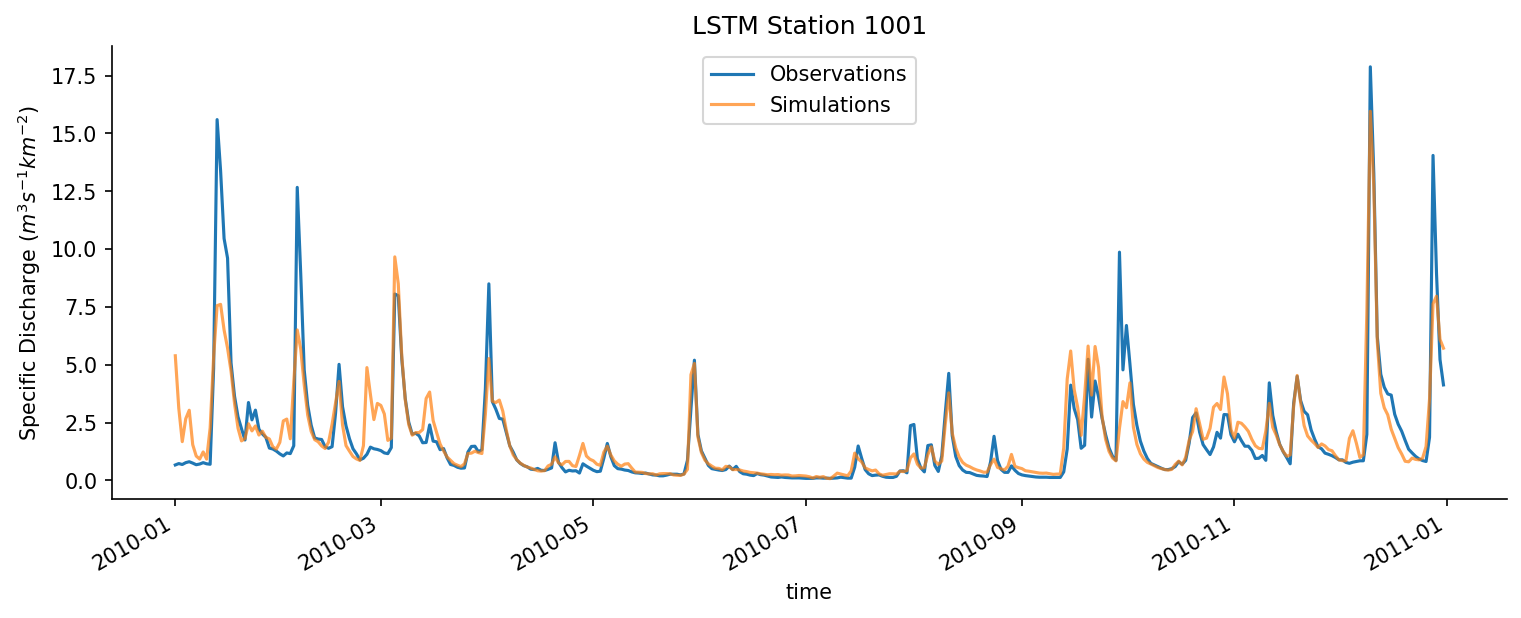

In [61]:
fig, ax = plt.subplots(figsize=(12, 4))
lstm_preds.isel(station_id=0).sel(time="2010")["obs"].plot(ax=ax, label="Observations")
lstm_preds.isel(station_id=0).sel(time="2010")["sim"].plot(ax=ax, label="Simulations", alpha=0.7)
ax.set_ylabel("Specific Discharge ($m^3 day^{-1} km^{-2}$)")
ax.set_title(f"LSTM Station {lstm_preds.isel(station_id=0).station_id.values}")
plt.legend()
sns.despine()

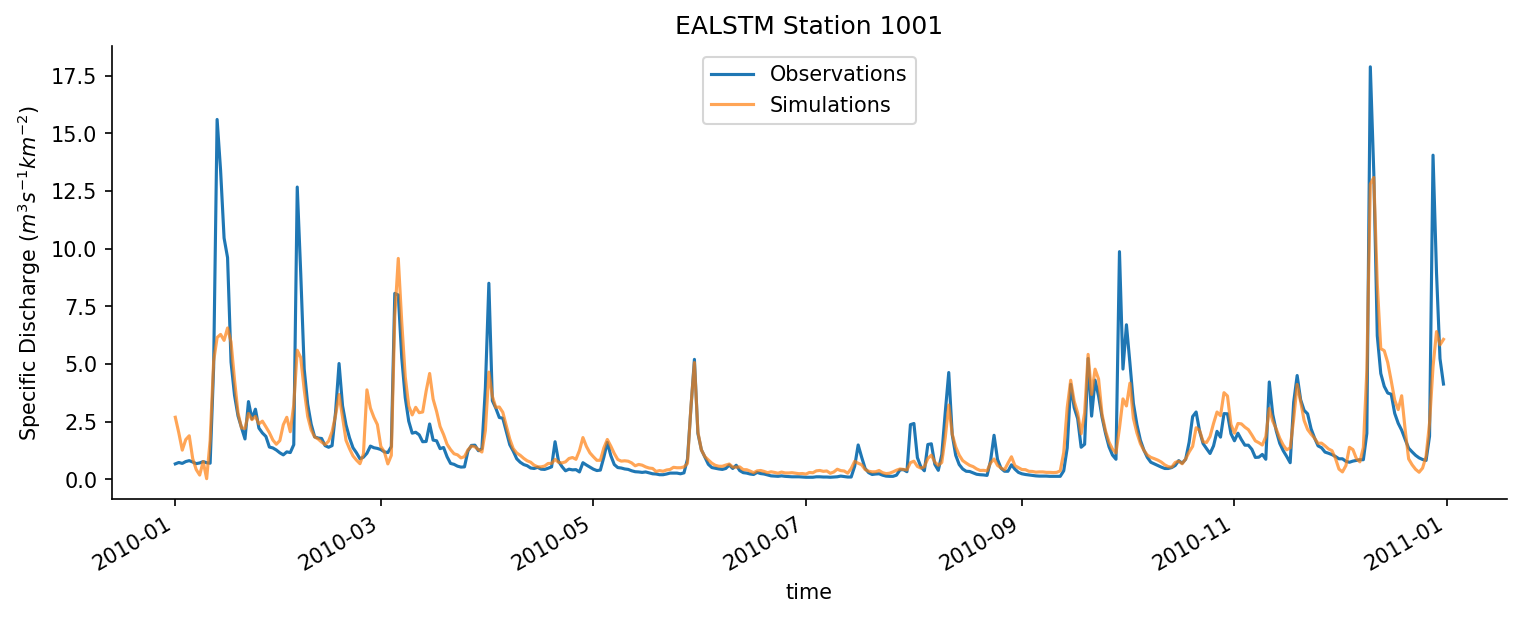

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))
ealstm_preds.isel(station_id=0).sel(time="2010")["obs"].plot(ax=ax, label="Observations")
ealstm_preds.isel(station_id=0).sel(time="2010")["sim"].plot(ax=ax, label="Simulations", alpha=0.7)
# less_ealstm_preds.isel(station_id=0).sel(time="2010")["sim"].plot(ax=ax, label="Less Vars", alpha=0.7)
ax.set_ylabel("Specific Discharge ($m^3 day^{-1} km^{-2}$)")
ax.set_title(f"EALSTM Station {ealstm_preds.isel(station_id=0).station_id.values}")
plt.legend()
sns.despine()

# Error Metrics

In [63]:
from src.analysis.evaluation import spatial_rmse, spatial_r2, spatial_nse
from src.analysis.evaluation import temporal_rmse, temporal_r2, temporal_nse
from src.analysis.evaluation import _nse_func, _rmse_func, _r2_func

In [64]:
def error_func(preds_xr: xr.Dataset, error_str: str) -> pd.DataFrame:
    lookup = {
        "nse": _nse_func,
        "rmse": _rmse_func,
        "r2": _r2_func,
    }
    error_func = lookup[error_str]
    
    df = preds_xr.to_dataframe()
    df = df.dropna(how='any')
    df = df.reset_index().set_index("time")

    station_ids = df["station_id"].unique()
    errors = []
    for station_id in station_ids:
        d = df.loc[df["station_id"] == station_id]
        if error_str == "rmse":
            _error_calc = error_func(d["obs"].values, d["sim"].values, n_instances=d.size)
        else:
            _error_calc = error_func(d["obs"].values, d["sim"].values)
        errors.append(_error_calc)

    error = pd.DataFrame({"station_id": station_ids, error_str: errors})
    
    return error

In [65]:
errors = [ 
    error_func(ealstm_preds, "nse").set_index('station_id'),
    error_func(ealstm_preds, "r2").set_index('station_id'), 
    error_func(ealstm_preds, "rmse").set_index('station_id'),
]
ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(lstm_preds, "nse").set_index('station_id'),
    error_func(lstm_preds, "r2").set_index('station_id'), 
    error_func(lstm_preds, "rmse").set_index('station_id'),
]
lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(less_ealstm_preds, "nse").set_index('station_id'),
    error_func(less_ealstm_preds, "r2").set_index('station_id'), 
    error_func(less_ealstm_preds, "rmse").set_index('station_id'),
]
less_ealstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

errors = [ 
    error_func(less_lstm_preds, "nse").set_index('station_id'),
    error_func(less_lstm_preds, "r2").set_index('station_id'), 
    error_func(less_lstm_preds, "rmse").set_index('station_id'),
]
less_lstm_df = errors[0].join(errors[1].join(errors[2])).reset_index()

# Plot CDF of NSE

In [66]:
ealstm_nse = (
    error_func(ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
lstm_nse = (
    error_func(lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)
less_ealstm_nse = (
    error_func(less_ealstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)

less_lstm_nse = (
    error_func(less_lstm_preds, "nse")
    .sort_values('nse')
    .reset_index()
    .drop('index', axis=1)
)

ealstm_nse['negative'] = ealstm_nse['nse'] < 0
lstm_nse['negative'] = lstm_nse['nse'] < 0

less_ealstm_nse['negative'] = less_ealstm_nse['nse'] < 0
less_lstm_nse['negative'] = less_lstm_nse['nse'] < 0

print(f"LSTM: {lstm_nse['negative'].sum()}")
print(f"EALSTM: {ealstm_nse['negative'].sum()}")
print(f"LSTM Less Vars: {less_lstm_nse['negative'].sum()}")
print(f"EALSTM Less Vars: {less_ealstm_nse['negative'].sum()}")

LSTM: 5
EALSTM: 13
LSTM Less Vars: 12
EALSTM Less Vars: 30


In [67]:
def plot_nse_cdf(nse_df):
    median_nse = nse_df.loc[nse_df["nse"] != -np.inf, 'nse'].median()

    scale = 1
    fig, ax = plt.subplots(figsize=(12*scale, 8*scale))

    # plot the points
    ax.scatter(nse_df['nse'], nse_df.index, alpha=0.06)

    ymax = nse_df.index.max()
    ax.axvline(median_nse, ymin=0, ymax=ymax, color='k', ls='--', label='Median NSE', alpha=0.7)

    # beautify the plot
    ax.set_ylim(-5, ymax*1.1)
    ax.set_xlim(-0.1, 1)

    ax.legend()

    ax.set_title(f'Station NSE - Median: {median_nse:.2f}\n{nse_df.negative.sum()} Stations with negative NSE')
    ax.set_xlabel('NSE')
    ax.set_ylabel('Cumulative Number of Stations');

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);

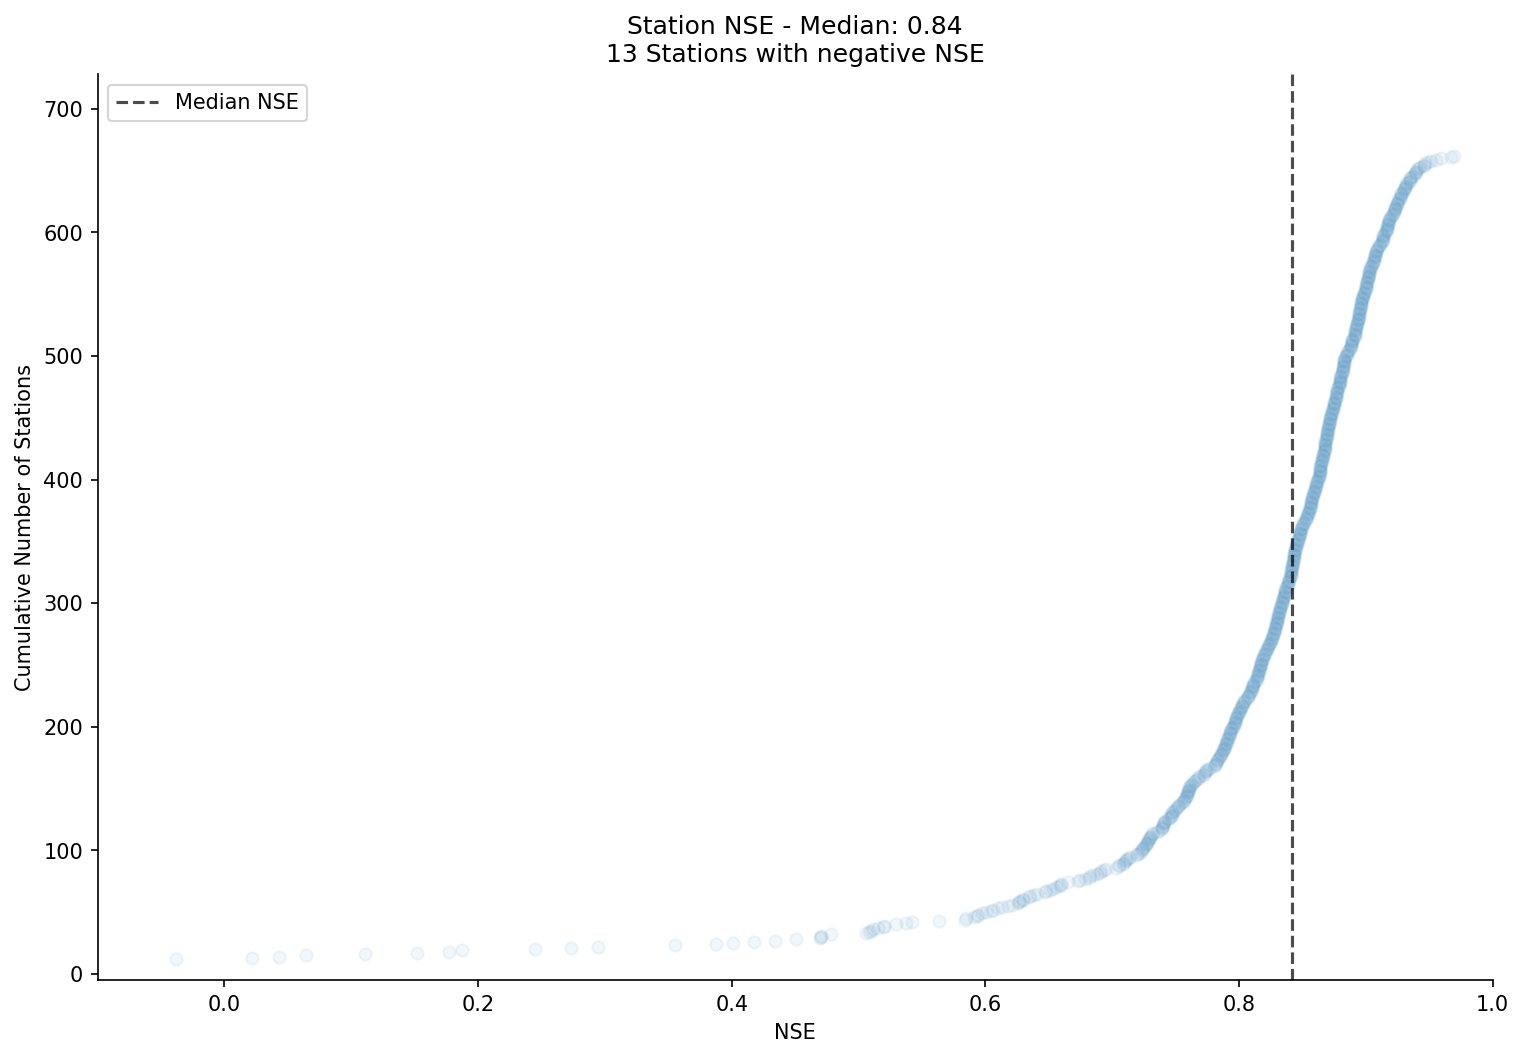

In [68]:
plot_nse_cdf(ealstm_nse)

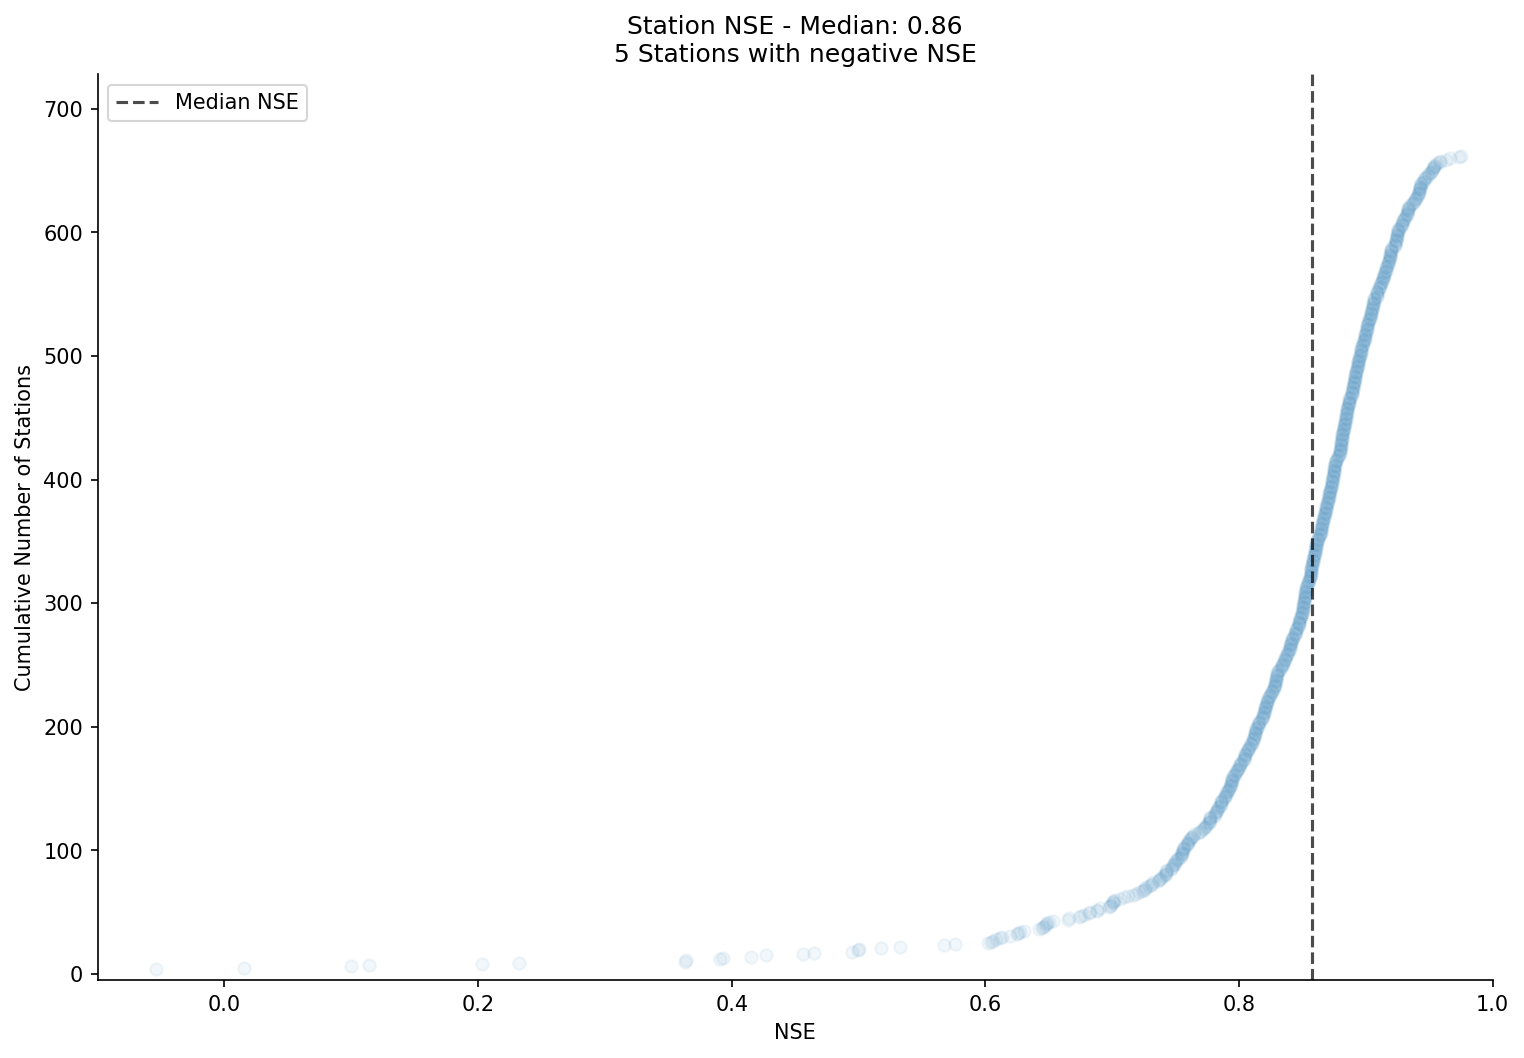

In [69]:
plot_nse_cdf(lstm_nse)

# 13 catchments

In [70]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [71]:
lstm_13 = lstm_df.loc[np.isin(lstm_df["station_id"], catchment_ids)]
lstm_13["catchment_name"] = catchment_names
ealstm_13 = ealstm_df.loc[np.isin(ealstm_df["station_id"], catchment_ids)]
ealstm_13["catchment_name"] = catchment_names

In [72]:
ealstm_13.set_index('station_id')

nse        r2      rmse        catchment_name
station_id                                                    
12002       0.834102  0.834460  0.538002              Dee@Park
15006       0.904312  0.904400  0.511382         Tay@Ballathie
27009       0.881502  0.881704  0.308297          Ouse@Skelton
27034       0.863907  0.863998  0.860223           Ure@Kilgram
27041       0.894845  0.894845  0.150864  Derwent@Buttercrambe
39001       0.891706  0.891898  0.141583       Thames@Kingston
39081       0.808840  0.809190  0.192992          Ock@Abingdon
43021       0.897131  0.897505  0.150406            Avon@Knapp
47001       0.925457  0.925478  0.440606      Tamar@Gunnislake
54001       0.892845  0.892857  0.246286        Severn@Bewdley
54057       0.895788  0.895899  0.193132            Severn@Haw
71001       0.894207  0.894214  0.626535     Ribble@Samlesbury
84013       0.930146  0.930185  0.395365        Clyde@Daldowie

In [73]:
lstm_13.set_index('station_id')

nse        r2      rmse        catchment_name
station_id                                                    
12002       0.851579  0.851623  0.508875              Dee@Park
15006       0.923598  0.923609  0.456951         Tay@Ballathie
27009       0.903644  0.903649  0.278006          Ouse@Skelton
27034       0.864664  0.864983  0.857827           Ure@Kilgram
27041       0.893957  0.894300  0.151499  Derwent@Buttercrambe
39001       0.919731  0.919908  0.121894       Thames@Kingston
39081       0.864230  0.864231  0.162645          Ock@Abingdon
43021       0.864765  0.870347  0.172451            Avon@Knapp
47001       0.941619  0.941629  0.389925      Tamar@Gunnislake
54001       0.918881  0.918952  0.214287        Severn@Bewdley
54057       0.900006  0.900302  0.189183            Severn@Haw
71001       0.890036  0.890041  0.638765     Ribble@Samlesbury
84013       0.939089  0.939117  0.369191        Clyde@Daldowie

## plot function

In [26]:
from typing import (Tuple, Dict, Optional, List, Union, Any)

def remove_invalid_vals(x, y) -> Tuple[np.ndarray, np.ndarray]:
    """check for infinite or nan values
    
    Required for np.polyfit:
    https://stackoverflow.com/a/13693657/9940782
    """
    isfinite = np.isfinite(y) & np.isfinite(x)
    notnull = pd.notnull(y) & pd.notnull(x)
    
    x = x[isfinite & notnull]
    y = y[isfinite & notnull]
    
    return x, y
    

def plot_1_1_line(x: np.ndarray, ax) -> plt.Axes:
    # plot 1:1 line
    line_1_1_x = np.linspace(x.min(), x.max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line', alpha=0.5)
    return ax


def plot_scatter(x: np.ndarray, y: np.ndarray, ax, one_to_one: bool = True, **kwargs) -> plt.Axes:
    """Scatter plot of x vs. y"""
    # plot scatter
    ax.plot(x, y, 'kx', **kwargs)
    
    if one_to_one:
        # plot 1:1 line
        ax = plot_1_1_line(x, ax)

    return ax


def plot_reg_line(x: np.ndarray, y: np.ndarray, ax, auto_label: bool = True, **kwargs):
    """plot linear regression line of x vs. y"""
    # plot regression line
    x, y = remove_invalid_vals(x, y)
    m, b = np.polyfit(x, y, 1)
    reg = (m * x + b)
    if auto_label:
        label = f'Regression Line: {m:.2f}X + {b:.2f}'
        ax.plot(x, reg, label=label, **kwargs)
    else:
        ax.plot(x, reg, **kwargs)

    return ax


def plot_station_scatter(
    df: pd.DataFrame, station_id: str, metrics_df: Optional[pd.DataFrame] = None, ax=None,
    target_var: str = 'discharge_spec',
    station_name: Optional[str] = None
):
    # select station & data
    d = df.query(f"station_id == '{station_id}'").drop(columns='station_id')
    x = d[target_var]
    y = d.preds
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()
    
    # plot scatter
    kwargs = dict(alpha=0.6, label='Data Point')
    ax = plot_scatter(x, y, ax, **kwargs)

    # plot regression line
    kwargs = dict(color = '#7bd250', ls='--')
    ax = plot_reg_line(x, y, ax=ax, **kwargs)

    # make the plot pretty
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {station_id}' + f" {station_name}" if station_name is not None else f'Station {station_id}'
    ax.set_title(title)

    ax.legend();
    
    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return fig, ax


def plot_station(
    df: pd.DataFrame, 
    station_id: str, 
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    station_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
):
    """Plot the Observed vs. Preds for the station_id"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
    
    if 'month' in df.columns:
        df = df.drop(columns='month')
    
    # plot the station
    if plot_years is None:
        df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    else:
        (
            df.loc[np.isin(df.index.year, plot_years)]
            .query(f"station_id == '{station_id}'")
            .drop(columns='station_id').plot(ax=ax)
        )
    
    # get the error metrics
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    nse_val = metrics_df.query(f"station_id == '{station_id}'").nse.values[0]
    # set the title
    station_title = f"{station_id} {station_name}" if station_name is not None else station_id
    ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")
    
    return fig, ax

Text(0.5, 0.98, 'LSTM')

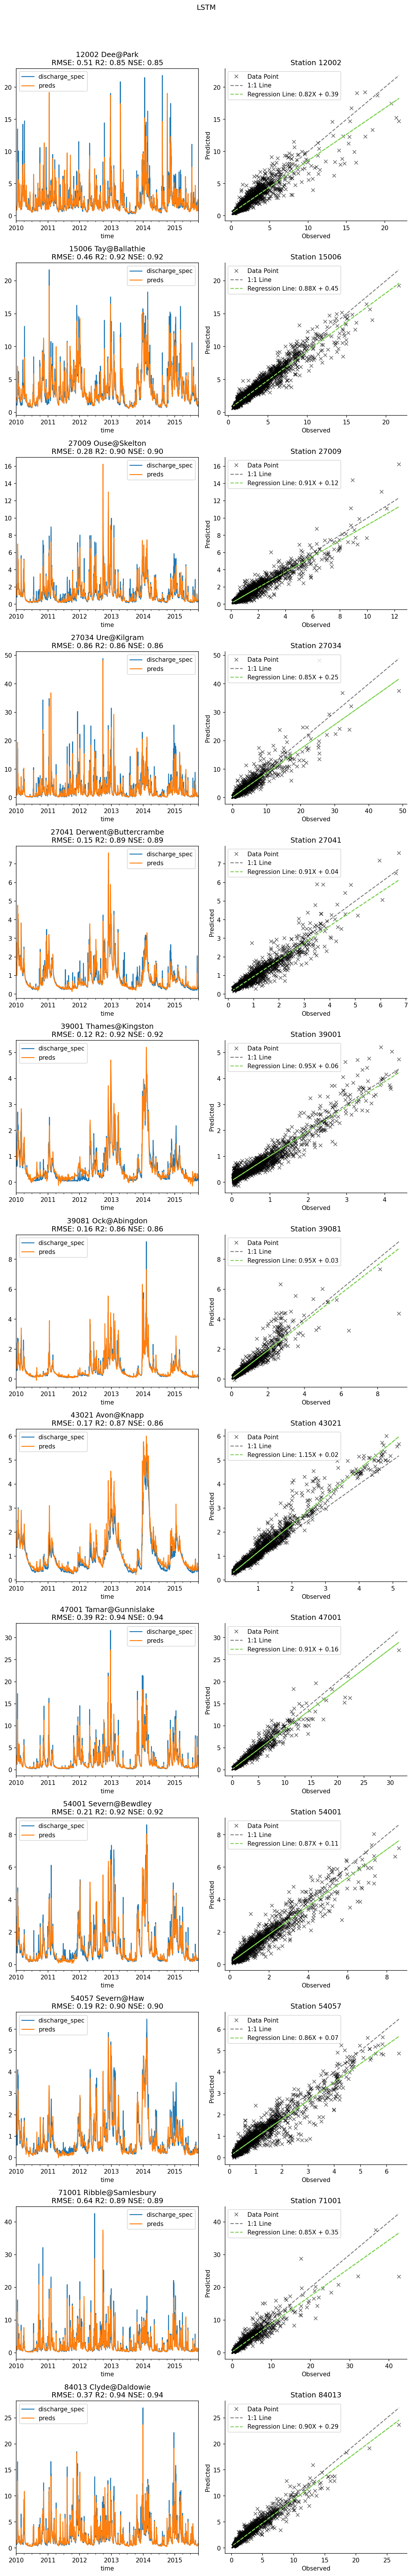

In [74]:
df = lstm_preds.to_dataframe().reset_index().set_index("time").rename(columns={"obs": "discharge_spec", 'sim': 'preds'})

plot_years = None # [2014]
scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), lstm_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
        plot_station_scatter(df, int(station_id), lstm_13, ax=axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("LSTM")

Text(0.5, 0.98, 'EALSTM')

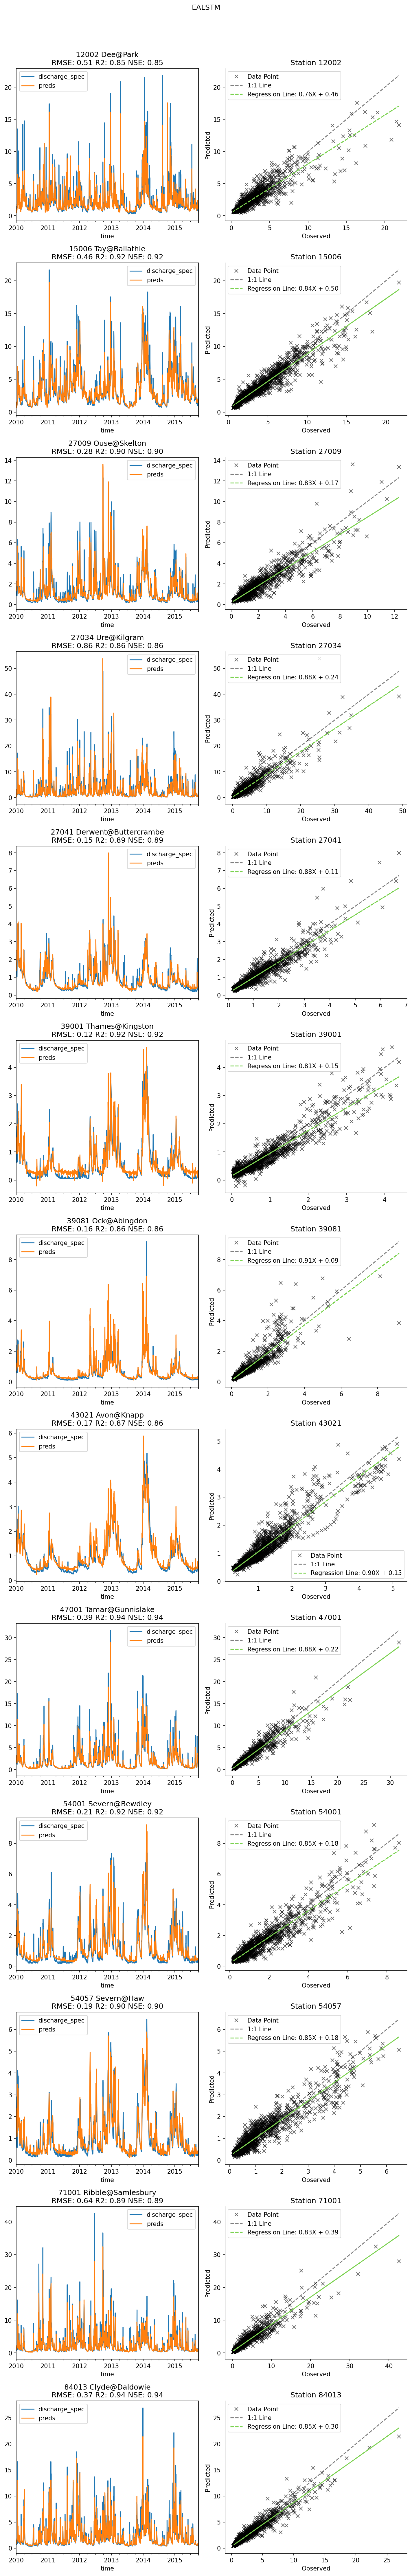

In [75]:
df = ealstm_preds.to_dataframe().reset_index().set_index("time").rename(columns={"obs": "discharge_spec", 'sim': 'preds'})

plot_years = None # [2014]
scale = 0.8
fig, axs = plt.subplots(13, 2, figsize=(12*scale, 6*scale*13))

for ix, (station_id, station_name) in enumerate(zip(catchment_ids, catchment_names)):
#     fig, axs = plt.subplots(1, 2, figsize=(12*scale, 6*scale))
    try:
        plot_station(df, int(station_id), lstm_df, ax=axs[ix, 0], station_name=station_name, plot_years=plot_years)
        plot_station_scatter(df, int(station_id), ealstm_13, ax=axs[ix, 1])
    except TypeError:
        print(f"** {station_name} data for years {plot_years if plot_years is not None else 'any'} does not exist in the predictions! **")
        
    plt.tight_layout()

fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("EALSTM")

# Geographical Plots

In [76]:
import geopandas as gpd

shp_path = Path(
    "/home/jovyan/runoff_uk_lstm/data/CAMELS/CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
)
assert shp_path.exists()

In [77]:
# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')

In [78]:
# create spatial dataframe
assert lstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
lstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(lstm_df.set_index('station_id'))
)

In [79]:
# create spatial dataframe
assert ealstm_df['station_id'].dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
ealstm_gdf = gpd.GeoDataFrame(
    geo_df.set_index('ID_STRING').join(ealstm_df.set_index('station_id'))
)

ealstm_gdf.head()

ID                       SOURCE VERSION    EXPORTED  \
ID_STRING                                                              
10002       10002.0  National River Flow Archive     1.3  2018-02-12   
10003       10003.0  National River Flow Archive     1.3  2018-02-12   
1001         1001.0  National River Flow Archive     1.3  2018-02-12   
101002     101002.0  National River Flow Archive     1.3  2018-02-12   
101005     101005.0  National River Flow Archive     1.3  2018-02-12   

                                                    geometry       nse  \
ID_STRING                                                                
10002      POLYGON ((410125.0000999998 848525.0000999998,...  0.713673   
10003      POLYGON ((394725.0000999998 830350.0000999998,...  0.879496   
1001       POLYGON ((326225.0000999998 954900.0000999998,...  0.814110   
101002     POLYGON ((450375.0000999998 88125.00009999983,...  0.789459   
101005     POLYGON ((453125.0000999998 83525.00009999983,...  0.843346   

                 r2      rmse  
ID_STRING                      
10002      0.715297  0.470540  
10003      0.879570  0.233105  
1001       0.814218  0.519706  
101002     0.791806  0.311472  
101005     0.843738  0.305144

# Get UK Boundaries

Get the COUNTY SHAPE data [here:](https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D)
```
!wget https://opendata.arcgis.com/datasets/1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!unzip 1919db8ffcc5445ea4ba5b8a10acfccd_0.zip
!mkdir Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
!mv Counties* Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC
```

Get all of these shapefiles and merge into one big polygon
```python
uk = gpd.read_file(data_dir / "gcloud/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC/Counties_and_Unitary_Authorities_April_2019_Boundaries_EW_BFC.shp")
uk.plot()

from shapely.ops import unary_union  # cascaded_union, 
uk_bound = unary_union([p for p in uk.geometry])
uk_bound = gpd.GeoSeries(uk_bound)
```

[Link to CRS Discussion](https://communityhub.esriuk.com/geoxchange/2012/3/26/coordinate-systems-and-projections-for-beginners.html#:~:text=If%20you%20work%20with%20UK,that%20you%20should%20know%20about.&text=Web%20Mercator%20is%20a%20PCS,36%20used%20for%20British%20maps)


![title](https://static1.squarespace.com/static/55bb8935e4b046642e9d3fa7/55bb8e8ee4b03fcc125a74c0/55bb8e91e4b03fcc125a7a67/1331725592717/1000w/coordsys_diagram.png)


In [80]:
world = gpd.read_file(data_dir / "gcloud/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")
# uk.plot(facecolor='none', edgecolor='k')

In [81]:
ealstm_gdf.crs = None
ealstm_gdf.crs = {'init' :'epsg:27700'}  # 4277  27700
lstm_gdf.crs = {'init' :'epsg:27700'}  

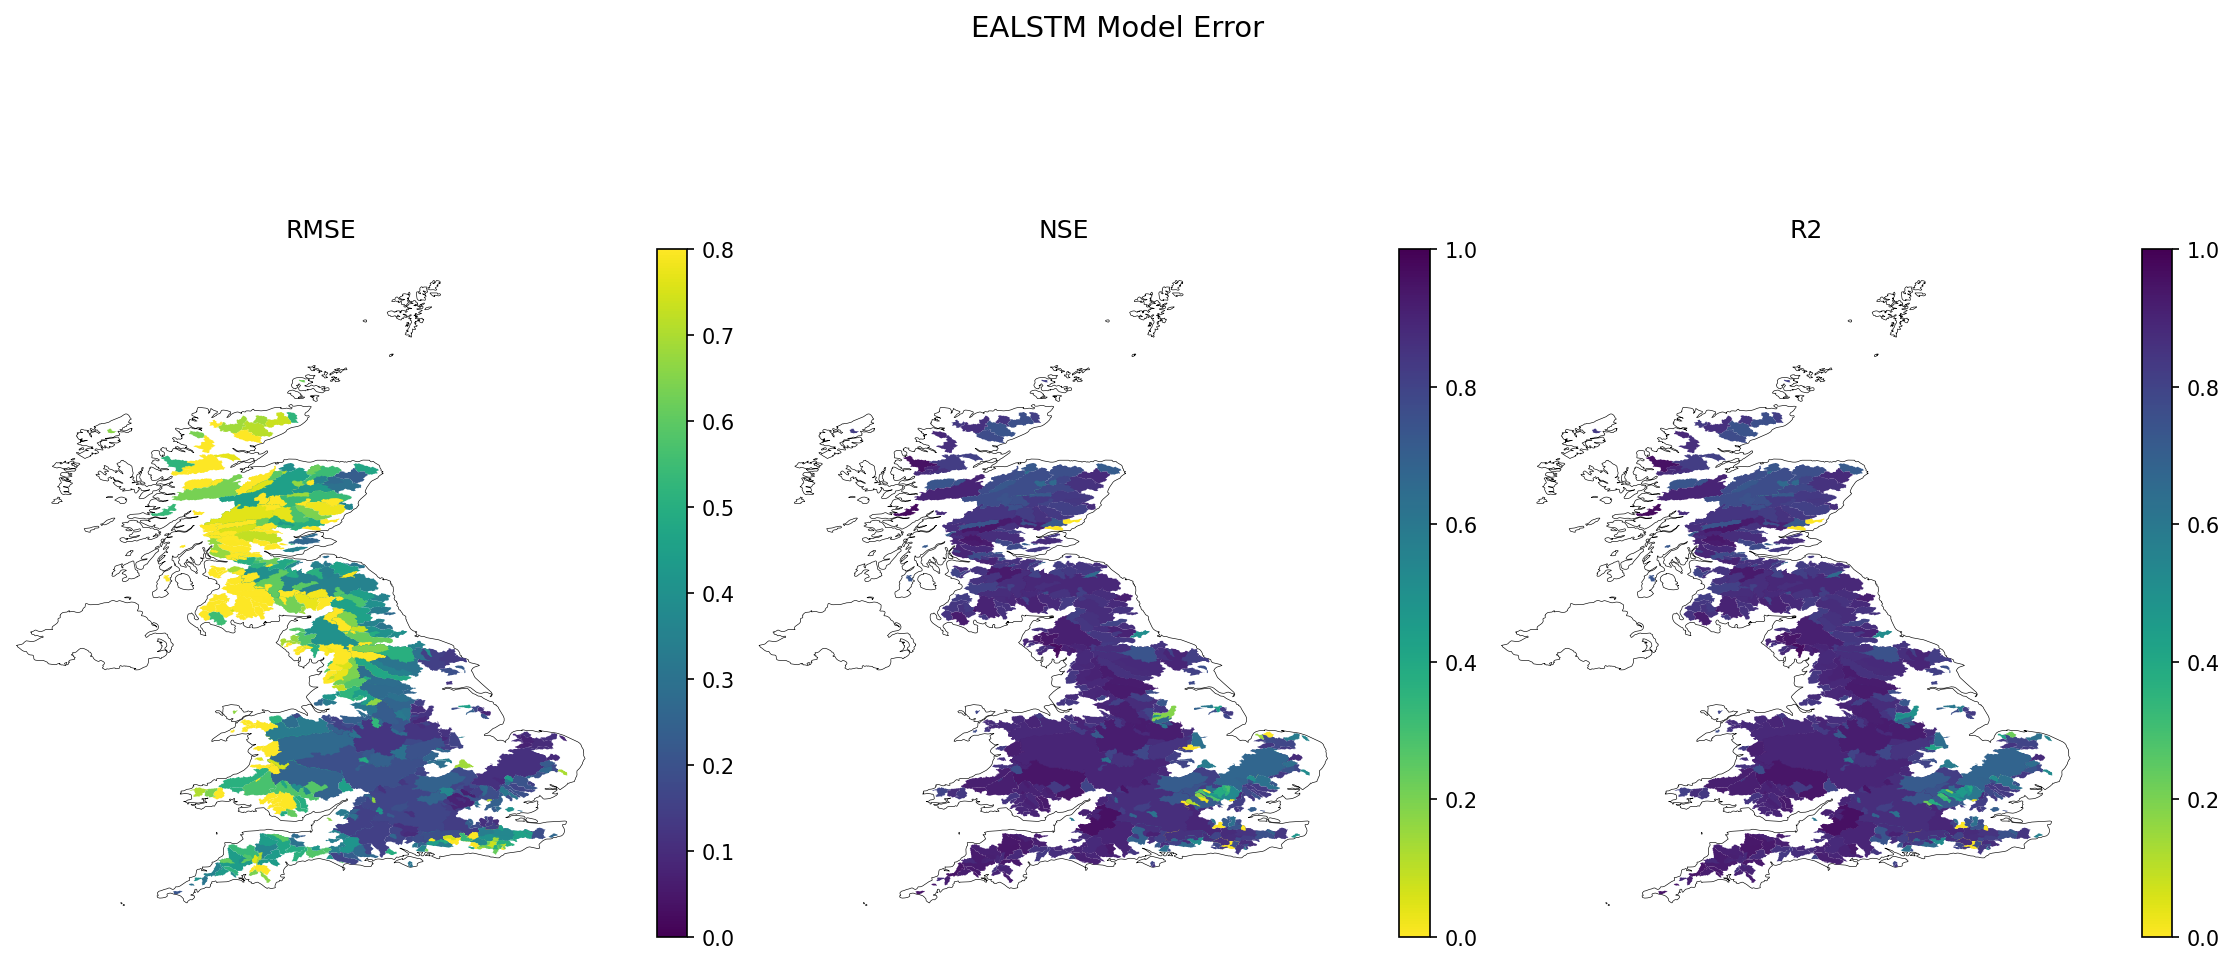

In [82]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

metric = "nse"
opts = {
    "rmse": {"vmin": 0, "vmax": 0.8, 'cmap': 'viridis'},   # rmse   
    "nse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'},    # nse   
    "r2": {"vmin": 0, "vmax": 1, 'cmap': 'viridis_r'}    # r2  
}

for ix, metric in enumerate(["rmse", "nse", "r2"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    ealstm_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

    # for key in ax.spines.keys():
    #     ax.spines[key].set_visible(False)
    ax.set_xlim([-8.2, 2.5])
    ax.axis('off');

    ax.set_title(metric.upper())
    
fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("EALSTM Model Error", size=14);

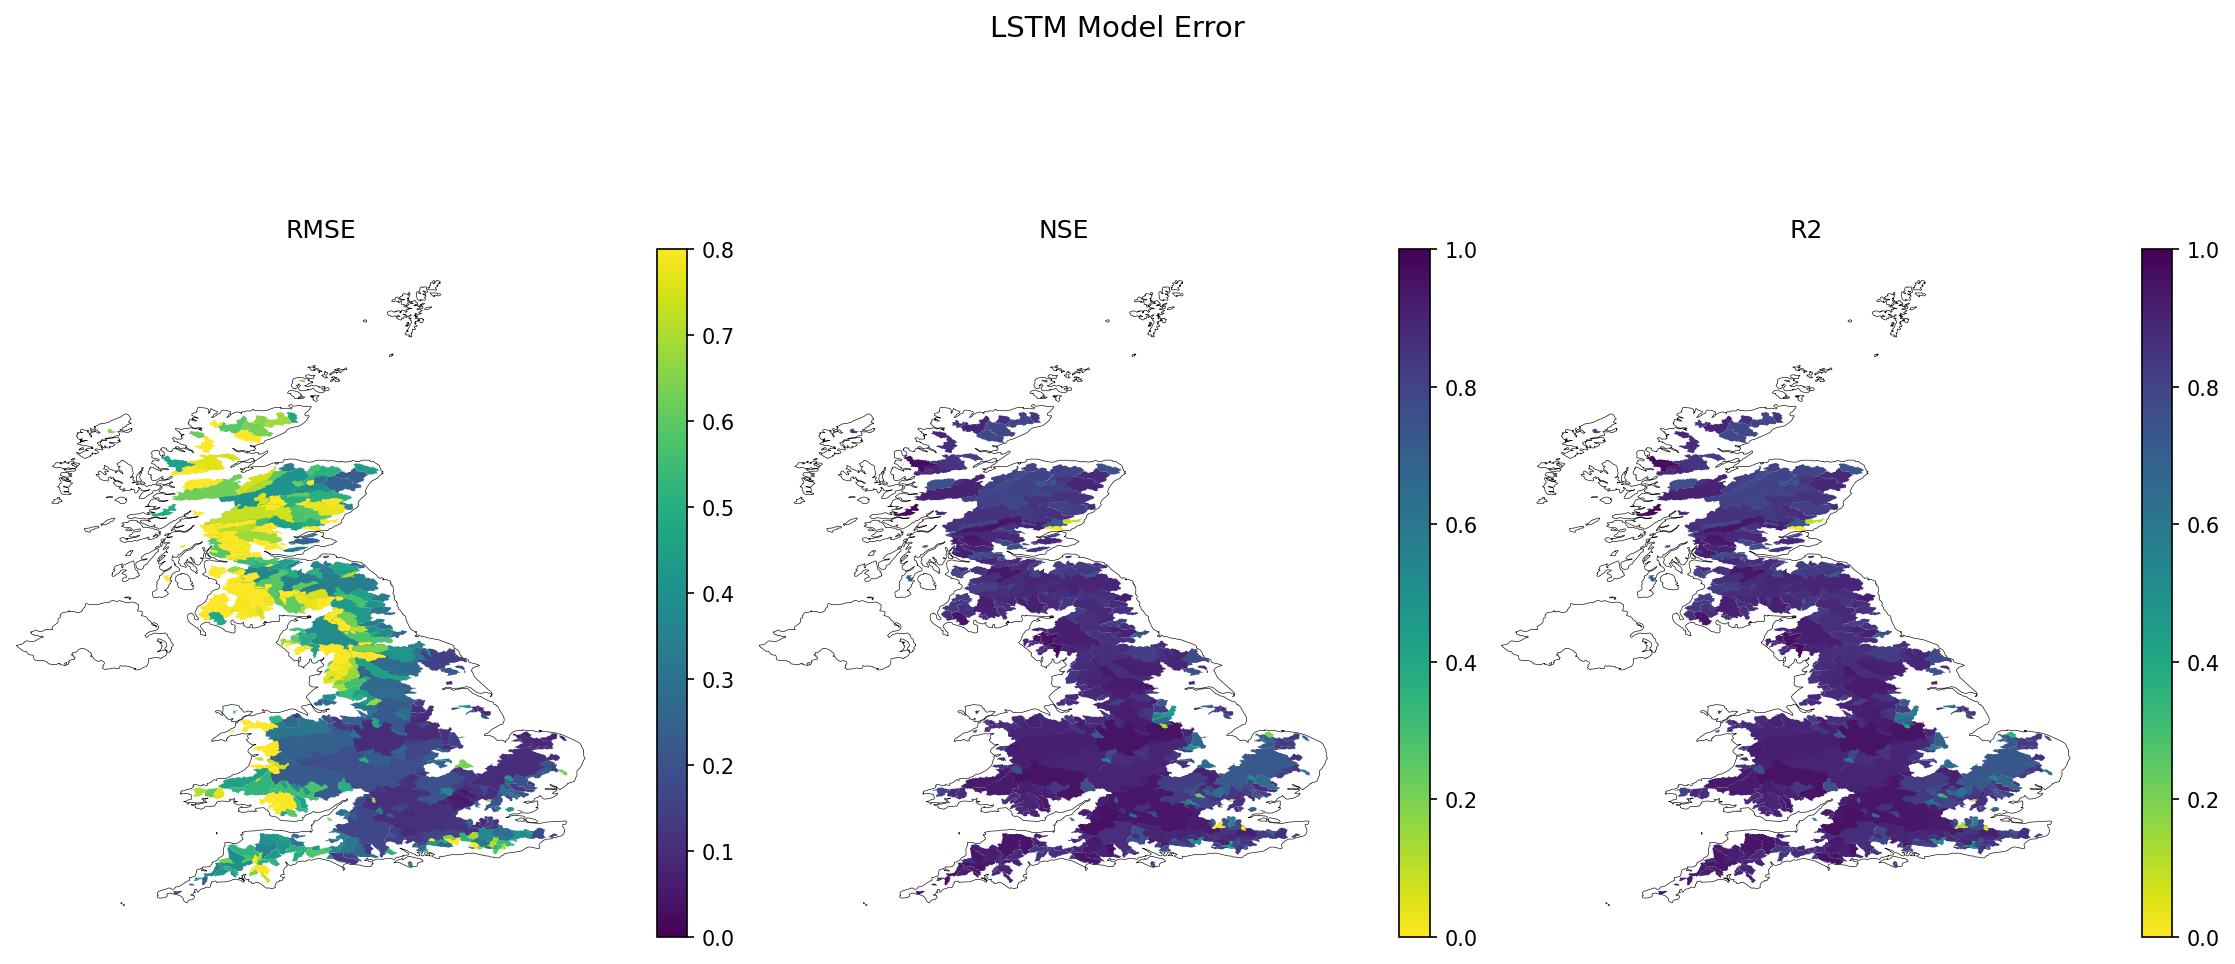

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

for ix, metric in enumerate(["rmse", "nse", "r2"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2) # depends on the user needs

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
    # plot the chloropleth
    lstm_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);

    # for key in ax.spines.keys():
    #     ax.spines[key].set_visible(False)
    ax.set_xlim([-8.2, 2.5])
    ax.axis('off');

    ax.set_title(metric.upper())
    
fig.tight_layout(rect=[0, 0.03, 1, 0.965])
fig.suptitle("LSTM Model Error", size=14);

# Locations of 13 test catchments

In [37]:
stations = static.station_id.values
names = static.gauge_name.values
latlons = np.array(list(zip(static.gauge_lat.values, static.gauge_lon.values)))

In [38]:
d = pd.DataFrame({'station_id': stations, 'lat': latlons[:, 0], 'lon': latlons[:, 1], 'name': names})

points = gpd.GeoDataFrame(
    d, geometry=gpd.points_from_xy(d.lon, d.lat)
)
points["id"] = points["station_id"]
points = points.set_index("station_id")
points.crs = {'init' :'epsg:4326'}  
points.head()
# points.plot()

lat   lon                     name             geometry    id
station_id                                                                 
1001        58.48 -3.27          Wick at Tarroul  POINT (-3.27 58.48)  1001
2001        58.14 -3.70   Helmsdale at Kilphedir   POINT (-3.7 58.14)  2001
2002        58.01 -3.88     Brora at Bruachrobie  POINT (-3.88 58.01)  2002
3003        57.96 -4.70  Oykel at Easter Turnaig   POINT (-4.7 57.96)  3003
4001        57.56 -4.54      Conon at Moy Bridge  POINT (-4.54 57.56)  4001

In [39]:
basins = ealstm_gdf.reset_index()[["ID", "geometry"]]
basins = basins.rename(columns={"ID":"station_id"}).set_index("station_id")
basins = basins.join(points.drop(columns="geometry"))
basins.crs = {'init' :'epsg:27700'}  
basins = basins.to_crs(epsg=4326)
basins.head()
# basins.plot()

geometry    lat   lon  \
station_id                                                                   
10002.0     POLYGON ((-1.832591530061402 57.52677172510972...  57.53 -1.83   
10003.0     POLYGON ((-2.089335278407181 57.36359210409901...  57.36 -2.09   
1001.0      POLYGON ((-3.266661394493432 58.47606499610154...  58.48 -3.27   
101002.0    POLYGON ((-1.288209653464926 50.69060168610302...  50.69 -1.29   
101005.0    POLYGON ((-1.2499408102372 50.64899447688404, ...  50.65 -1.25   

                                name      id  
station_id                                    
10002.0            Ugie at Inverugie   10002  
10003.0               Ythan at Ellon   10003  
1001.0               Wick at Tarroul    1001  
101002.0             Medina at Shide  101002  
101005.0    Eastern Yar at Budbridge  101005

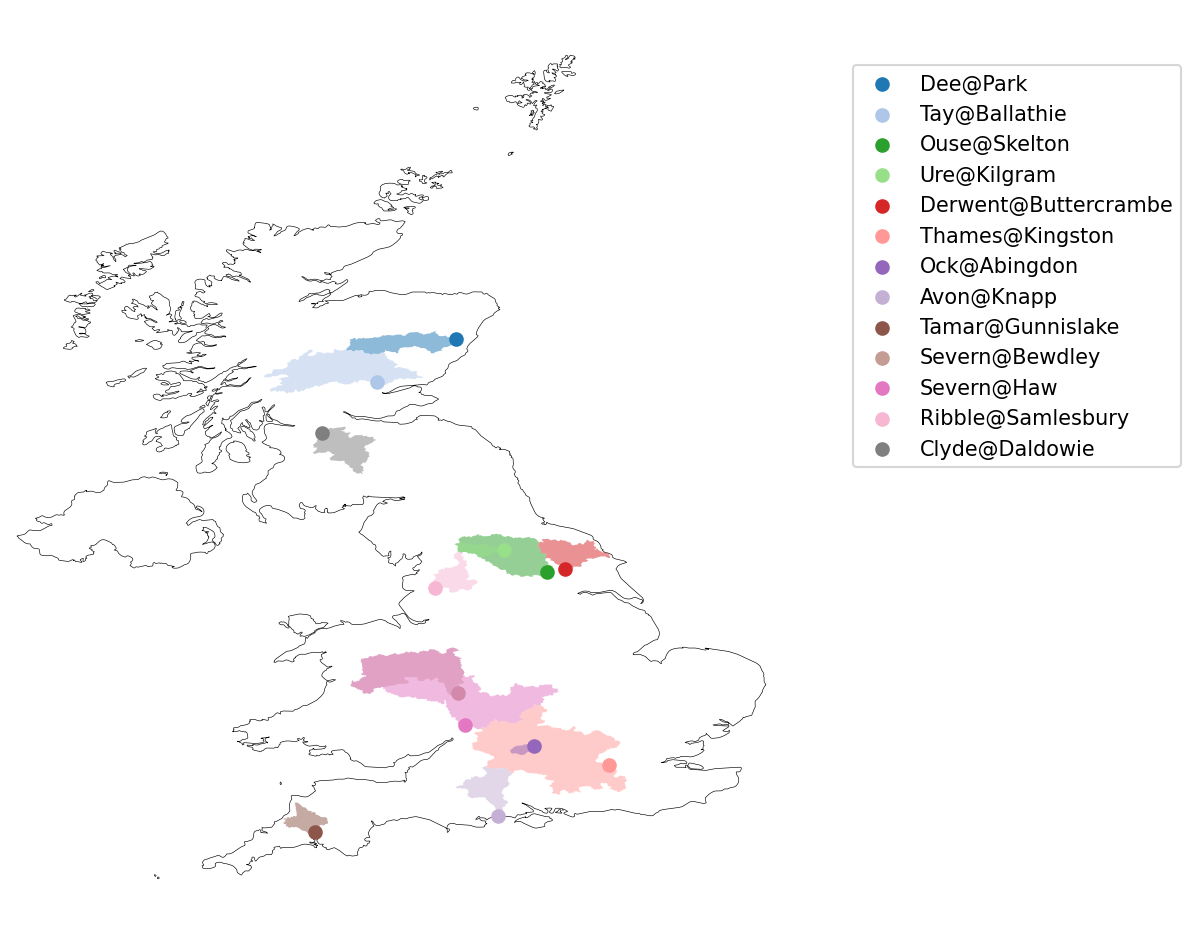

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
ax.set_xlim([-8.2, 2.5])
colors = np.array(mpl.cm.get_cmap('tab20').colors)
colors = np.vstack([colors[0:2], colors[4:]])

for ix, (c_id, c_name) in enumerate(zip(catchment_ids, catchment_names)):
    basins.loc[basins["id"] == c_id].plot(ax=ax, alpha=0.5, color=colors[ix])
    points.loc[points["id"] == c_id].plot(ax=ax, label=c_name, categorical=True, color=colors[ix])

plt.legend(loc=(1.04, 0.5))
ax.axis('off');